In [1]:
from TimeLLMProcessors import FixedModelTimeLLMProcessor

In [2]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go

In [3]:
from neuralforecast.models import TimeLLM
from neuralforecast.core import NeuralForecast

In [4]:
updated_df = updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [5]:
US_input_df = updated_df.copy()
US_input_df = US_input_df[US_input_df["location_name"] == "US"]
US_input_df = US_input_df[["date", "value"]]
US_input_df["date"] = pd.to_datetime(US_input_df["date"])
US_input_df.set_index("date", inplace = True)
US_input_df.sort_values(by = "date", inplace = True)
US_input_df["ds"] = US_input_df.index
US_input_df["unique_id"] = "series_1"
US_input_df.rename(columns = {"value": "y"}, inplace=True)

US_true_df = US_input_df.copy()

US_input_df = US_input_df.loc[:"12-15-2024"]

In [29]:
all_input_df = updated_df.copy()
all_input_df = all_input_df[["date", "value", "location_name"]]
all_input_df["date"] = pd.to_datetime(all_input_df["date"])
all_input_df.sort_values(by = ["date", "location_name"], inplace = True)
all_input_df.rename(columns = {"date": "ds", "value": "y", "location_name": "unique_id"}, inplace = True)

all_input_df = all_input_df[all_input_df["ds"] <= "12-15-2024"]
all_input_df.dropna(inplace=True)

In [30]:
US_input_df

,y,ds,unique_id
date,,,
2022-02-05,1091.0,2022-02-05,series_1
2022-02-12,1158.0,2022-02-12,series_1
2022-02-19,1490.0,2022-02-19,series_1
2022-02-26,1603.0,2022-02-26,series_1
2022-03-05,1791.0,2022-03-05,series_1
...,...,...,...
2024-11-16,2520.0,2024-11-16,series_1
2024-11-23,3084.0,2024-11-23,series_1
2024-11-30,4261.0,2024-11-30,series_1


In [31]:
all_input_df

,ds,y,unique_id
1286,2022-02-05,5.0,Alabama
1992,2022-02-05,1.0,Alaska
1450,2022-02-05,35.0,Arizona
4381,2022-02-05,16.0,Arkansas
4665,2022-02-05,30.0,California
...,...,...,...
1474,2024-12-14,140.0,Virginia
5445,2024-12-14,152.0,Washington
2558,2024-12-14,21.0,West Virginia
4067,2024-12-14,66.0,Wisconsin


In [9]:
US_true_df

,y,ds,unique_id
date,,,
2022-02-05,1091.0,2022-02-05,series_1
2022-02-12,1158.0,2022-02-12,series_1
2022-02-19,1490.0,2022-02-19,series_1
2022-02-26,1603.0,2022-02-26,series_1
2022-03-05,1791.0,2022-03-05,series_1
...,...,...,...
2025-05-17,1793.0,2025-05-17,series_1
2025-05-24,1665.0,2025-05-24,series_1
2025-05-31,1740.0,2025-05-31,series_1


In [10]:
"""
Prompt 1 I will have a barebones description of the dataset
Prompt 2 will be a very brief description of the dataset
Prompt 3 will be control prompt that I've been using
Prompt 4 will add upon prompt 3 with prediction instructions
Prompt 5 will contain prediction instructions and specific values in dataset
"""

"\nPrompt 1 I will have a barebones description of the dataset\nPrompt 2 will be a very brief description of the dataset\nPrompt 3 will be control prompt that I've been using\nPrompt 4 will add upon prompt 3 with prediction instructions\nPrompt 5 will contain prediction instructions and specific values in dataset\n"

In [11]:
prompt1 = "Flu hospitalizations dataframe"
prompt2 = "Data on weekly flu hospitalizations in the United States"
prompt3 = "This dataset contains data on weekly flu hospitalizations in the United States. There is a yearly (52 weeks) seasonality"
prompt4 = "This dataset contains data on weekly flu hospitalizations in the United States. There is a yearly (52 weeks) seasonality. Predict the next 4 steps given the input of 143 data points"
prompt5 = "This dataset contains data on weekly flu hospitalizations in the United States. There is a yearly (52 weeks) seasonality. Predict the next 4 steps given the input of 143 data points. In the winter the dataframe peaks at a value of 26812 and is at minimum in summer with 223. The median is 1330. In December we start seeing rapid increase and the peak tends to be in mid January."



prompt6 = "This dataset contains data on weekly flu hospitalizations in the United States. There is a yearly (52 weeks) seasonality. There is a peak in January, and there is a rapid increase in December in number of hospitalizations."


In [12]:
prompts = [prompt1, prompt2, prompt3, prompt4, prompt5, prompt6]

In [13]:
#US only Training Dataframes

US_forecasts = []

for prompt in prompts:
    nf = NeuralForecast(models = [TimeLLM(h = 4, llm = 'gpt2-medium', d_llm = 1024,
                                                       prompt_prefix = prompt, input_size = 16,
                                                       windows_batch_size=64, inference_windows_batch_size=64,
                                       max_steps = 50
                                                      )], freq = "W-SAT")
    nf.fit(df = US_input_df)
    fc = nf.predict(df = US_input_df)
    US_forecasts.append(fc)

[rank: 0] Seed set to 1
2025-06-24 17:48:55.730646: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 17:48:56.865228: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-24 17:48:58.177912: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-24 17:48:58.177993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-24 17:48:58.195477: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS fac

Successfully loaded model: gpt2-medium


/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | Temporal

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Successfully loaded model: gpt2-medium


/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | TemporalNorm       | 0      | train
3 | llm                 | GPT2Model          | 354 M  | eval 
4 | patch_embedding     | PatchEmbedding     | 1.5 K  | train
5 | mapping_layer       | Linear             | 51.5 M | train
6 | reprogramming_layer | ReprogrammingLayer | 3.2 M  | train
7 | output_projection   | FlattenHead        | 1.0 K  | train
8 | normalize

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Successfully loaded model: gpt2-medium


/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | TemporalNorm       | 0      | train
3 | llm                 | GPT2Model          | 354 M  | eval 
4 | patch_embedding     | PatchEmbedding     | 1.5 K  | train
5 | mapping_layer       | Linear             | 51.5 M | train
6 | reprogramming_layer | ReprogrammingLayer | 3.2 M  | train
7 | output_projection   | FlattenHead        | 1.0 K  | train
8 | normalize

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Successfully loaded model: gpt2-medium


/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | TemporalNorm       | 0      | train
3 | llm                 | GPT2Model          | 354 M  | eval 
4 | patch_embedding     | PatchEmbedding     | 1.5 K  | train
5 | mapping_layer       | Linear             | 51.5 M | train
6 | reprogramming_layer | ReprogrammingLayer | 3.2 M  | train
7 | output_projection   | FlattenHead        | 1.0 K  | train
8 | normalize

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Successfully loaded model: gpt2-medium


/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | TemporalNorm       | 0      | train
3 | llm                 | GPT2Model          | 354 M  | eval 
4 | patch_embedding     | PatchEmbedding     | 1.5 K  | train
5 | mapping_layer       | Linear             | 51.5 M | train
6 | reprogramming_layer | ReprogrammingLayer | 3.2 M  | train
7 | output_projection   | FlattenHead        | 1.0 K  | train
8 | normalize

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Successfully loaded model: gpt2-medium


/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | TemporalNorm       | 0      | train
3 | llm                 | GPT2Model          | 354 M  | eval 
4 | patch_embedding     | PatchEmbedding     | 1.5 K  | train
5 | mapping_layer       | Linear             | 51.5 M | train
6 | reprogramming_layer | ReprogrammingLayer | 3.2 M  | train
7 | output_projection   | FlattenHead        | 1.0 K  | train
8 | normalize

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [23]:
US_metrics_df = pd.DataFrame(columns=["MAE"])
for i in range(len(US_forecasts)):
    row_df = pd.DataFrame({"MAE": [mean_absolute_error(US_true_df.loc[US_forecasts[i]["ds"]]["y"], US_forecasts[i]["TimeLLM"])]}, index = [f"Forecast {i+1}"])
    US_metrics_df = pd.concat([US_metrics_df, row_df])


In [24]:
US_metrics_df

,MAE
Forecast 1,24519.693359
Forecast 2,24203.644653
Forecast 3,23534.441345
Forecast 4,23010.219238
Forecast 5,21411.600952
Forecast 6,21642.038208


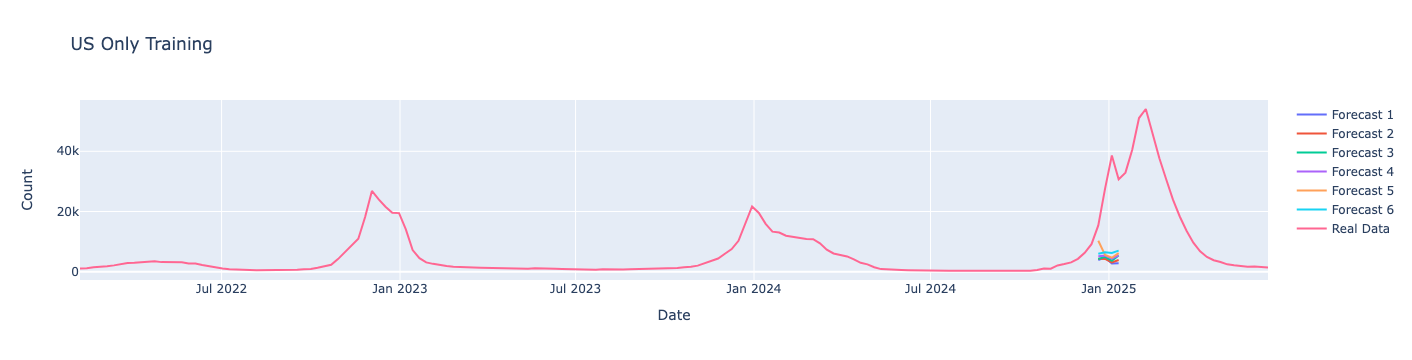

In [44]:
fig = go.Figure()
for i in range(len(US_forecasts)):
    fig.add_trace(go.Scatter(x = US_forecasts[i]["ds"], y = US_forecasts[i]["TimeLLM"], mode = "lines", name = f"Forecast {i+1}"))
fig.add_trace(go.Scatter(x = US_true_df.index, y = US_true_df["y"], mode = "lines", name = "Real Data"))
fig.update_layout(title = f"US Only Training", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
fig.show()

In [34]:
#All States Training Dataframes

all_forecasts = []

for prompt in prompts:
    nf = NeuralForecast(models = [TimeLLM(h = 4, llm = 'gpt2-medium', d_llm = 1024,
                                                       prompt_prefix = prompt, input_size = 16,
                                                       windows_batch_size=64, inference_windows_batch_size=64,
                                       max_steps = 50
                                                      )], freq = "W-SAT")
    nf.fit(df = all_input_df)
    fc = nf.predict(df = all_input_df)

    all_forecasts.append(fc)

[rank: 0] Seed set to 1


Successfully loaded model: gpt2-medium


/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:537: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | TemporalNorm       | 0      | train
3 | llm                 | GPT2Model          | 354 M  | eval 
4 | patch_embedding     | PatchEmbedding     | 1.5 K  | train
5 | mapping_layer       | Linear             | 51.5 M | train
6 | reprogramming_layer | ReprogrammingLayer | 3.2 M  | train
7 | output_projection   | FlattenHead        | 1.0 K  | train
8 | normalize_layers    | Re

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Successfully loaded model: gpt2-medium


/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:537: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | TemporalNorm       | 0      | train
3 | llm                 | GPT2Model          | 354 M  | eval 
4 | patch_embedding     | PatchEmbedding     | 1.5 K  | train
5 | mapping_layer       | Linear             | 51.5 M | train
6 | reprogramming_layer | ReprogrammingLayer | 3.2 M  | train
7 | output_projection   | FlattenHead        | 1.0 K  | train
8 | normalize_layers    | Re

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Successfully loaded model: gpt2-medium


/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:537: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | TemporalNorm       | 0      | train
3 | llm                 | GPT2Model          | 354 M  | eval 
4 | patch_embedding     | PatchEmbedding     | 1.5 K  | train
5 | mapping_layer       | Linear             | 51.5 M | train
6 | reprogramming_layer | ReprogrammingLayer | 3.2 M  | train
7 | output_projection   | FlattenHead        | 1.0 K  | train
8 | normalize_layers    | Re

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Successfully loaded model: gpt2-medium


/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:537: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | TemporalNorm       | 0      | train
3 | llm                 | GPT2Model          | 354 M  | eval 
4 | patch_embedding     | PatchEmbedding     | 1.5 K  | train
5 | mapping_layer       | Linear             | 51.5 M | train
6 | reprogramming_layer | ReprogrammingLayer | 3.2 M  | train
7 | output_projection   | FlattenHead        | 1.0 K  | train
8 | normalize_layers    | Re

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Successfully loaded model: gpt2-medium


/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:537: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | TemporalNorm       | 0      | train
3 | llm                 | GPT2Model          | 354 M  | eval 
4 | patch_embedding     | PatchEmbedding     | 1.5 K  | train
5 | mapping_layer       | Linear             | 51.5 M | train
6 | reprogramming_layer | ReprogrammingLayer | 3.2 M  | train
7 | output_projection   | FlattenHead        | 1.0 K  | train
8 | normalize_layers    | Re

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Successfully loaded model: gpt2-medium


/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:537: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | TemporalNorm       | 0      | train
3 | llm                 | GPT2Model          | 354 M  | eval 
4 | patch_embedding     | PatchEmbedding     | 1.5 K  | train
5 | mapping_layer       | Linear             | 51.5 M | train
6 | reprogramming_layer | ReprogrammingLayer | 3.2 M  | train
7 | output_projection   | FlattenHead        | 1.0 K  | train
8 | normalize_layers    | Re

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [40]:
all_forecasts[0][all_forecasts[0]["unique_id"] == "US"]

,unique_id,ds,TimeLLM
180,US,2024-12-21,4262.972656
181,US,2024-12-28,5150.037109
182,US,2025-01-04,2895.924805
183,US,2025-01-11,2947.753418


In [41]:

all_metrics_df = pd.DataFrame(columns = ["MAE"])
for i in range(len(all_forecasts)):
    df_slice = all_forecasts[i][all_forecasts[i]["unique_id"] == "US"]
    
    row_df = pd.DataFrame({"MAE": [mean_absolute_error(US_true_df.loc[df_slice["ds"]]["y"], df_slice["TimeLLM"])]}, index = [f"Forecast {i+1}"])
    all_metrics_df = pd.concat([all_metrics_df, row_df])

In [42]:
all_metrics_df

,MAE
Forecast 1,24246.828003
Forecast 2,24812.680115
Forecast 3,25542.557739
Forecast 4,24807.534912
Forecast 5,24814.980591
Forecast 6,25053.607361


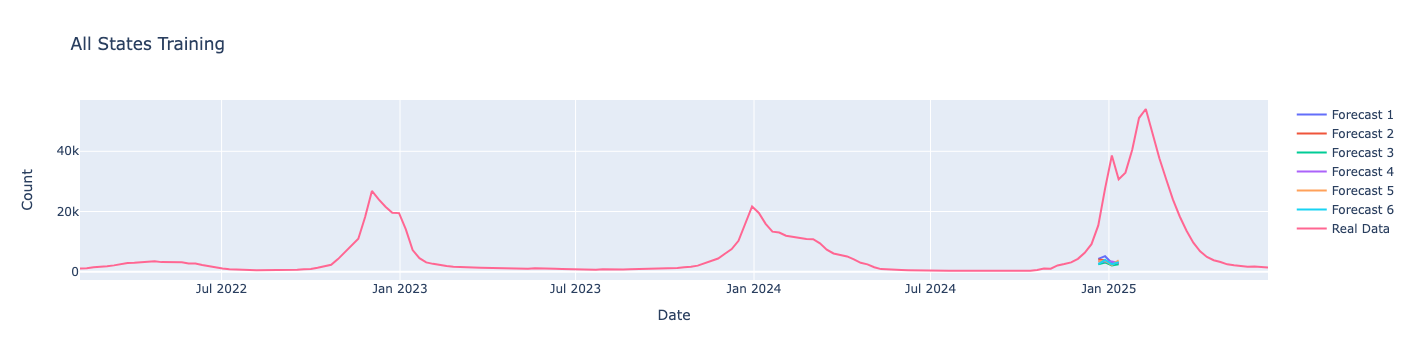

In [43]:
fig = go.Figure()
for i in range(len(all_forecasts)):
    sliced_fc = all_forecasts[i][all_forecasts[i]["unique_id"] == "US"]
    
    fig.add_trace(go.Scatter(x = sliced_fc["ds"], y = sliced_fc["TimeLLM"], mode = "lines", name = f"Forecast {i+1}"))
fig.add_trace(go.Scatter(x = US_true_df.index, y = US_true_df["y"], mode = "lines", name = "Real Data"))
fig.update_layout(title = f"All States Training", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
fig.show()